In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures   
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
data= pd.read_csv("./data.csv")
# Split the inputs and outputs into separate arrays
# x = data[ :, 0]
# y = data[:,1]
#training_data = data[:70]
feature_cols=['location',	'country' ,	'gender' ,	'age' ,	'vis_wuhan',	'from_wuhan',	'symptom1'	,'symptom2'	,'symptom3'	,'symptom4'	,'symptom5'	,'symptom6', 	'diff_sym_hos'
]
x=data[feature_cols]
y=data.result
# Convert 1-D arrays into 2-D because the commands later will require it
# x = np.expand_dims(x, axis=1)
# y = np.expand_dims(y, axis=1)
# Get 70% of the dataset as the training set. Put the remaining 30% in temporary variables: x_test and y_test.
x_train, x_both, y_train, y_both = train_test_split(x, y, test_size=0.30, random_state=3)
# Split the 30% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_both, y_both, test_size=0.50, random_state=3)
#another approach to divide data 
#train, validate, test = np.split(df.sample(frac=1, random_state=42), #60 training 20 validation 20 test 
                      # [int(.6*len(df)), int(.8*len(df))]) 


In [ ]:
df = pd.DataFrame(x) 
print(df.head())

In [ ]:
cor_matrix = df.corr()
print(cor_matrix)

In [ ]:
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# print(upper_tri)

In [ ]:
corr = data.corr()
corr.head()

In [ ]:
sns.heatmap(corr)


We will try to predict using the cross-validation dataset and calculate the accuracy between the expected output and the original output by random number of neighbors 

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_cv)
print(confusion_matrix(y_cv, y_pred))
print(classification_report(y_cv, y_pred))

[[114   2]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       116
           1       0.75      0.46      0.57        13

    accuracy                           0.93       129
   macro avg       0.85      0.72      0.77       129
weighted avg       0.92      0.93      0.92       129



True positive 114 out of 116
True negative are 7 out of 13

Find the optimal k by cross-validation scores by finding the highest score therefor will be the highest k


In [5]:
from sklearn.model_selection import cross_val_score
neighbors=[]
k_range=range(1,31)
cv_scores=[]
for k in (1, 20, 2):
    neighbors.append(k)
    knn2=KNeighborsClassifier ( n_neighbors=k)
    scores=cross_val_score(knn2,x_train,y_train,cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    

scores=cross_val_score(knn2,x_train,y_train,cv=10, scoring='accuracy')
print(scores)

[0.95081967 0.91803279 0.91803279 0.91803279 0.91666667 0.93333333
 0.91666667 0.98333333 0.98333333 0.9       ]


In [6]:
optimal_k=k_range[np.argmax(cv_scores)]
print(f" The optimal number of neigbors is {optimal_k} ")


 The optimal number of neigbors is 1 


1


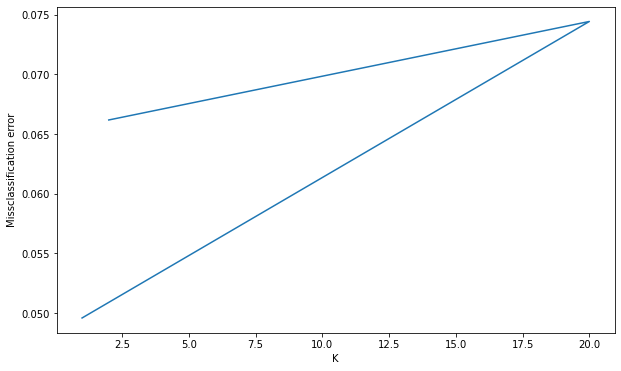

In [7]:

MSE=[1-x for x in cv_scores]

optimal_k =neighbors[MSE.index(min(MSE))]
print(optimal_k)
plt.figure(figsize=(10,6))
plt.plot(neighbors,MSE)
plt.xlabel("K")
plt.ylabel("Missclassification error")
plt.show()

In [8]:
knn3 = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute')
knn3.fit(x_train, y_train)
y_pred = knn3.predict(x_cv)
print(confusion_matrix(y_cv, y_pred))
print(classification_report(y_cv, y_pred))

[[112   4]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       116
           1       0.60      0.46      0.52        13

    accuracy                           0.91       129
   macro avg       0.77      0.71      0.74       129
weighted avg       0.91      0.91      0.91       129



In [31]:
#KNN
from sklearn.model_selection import GridSearchCV
rf_params = {
    'n_neighbors': [1,2, 3,4, 5,7,9,10,11,15,20],
    'metric':["minkowski","manhattan","euclidean"],
    'weights': ["distance","uniform"],
    
}
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, rf_params, cv=10, scoring='accuracy')
# grid = GridSearchCV(clf, rf_params, cv=5, scoring='accuracy')
# grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(x_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy:0.9520218579234973


In [ ]:
pd.crosstab(y_cv, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Tunning hyperparameter 'k'

In [ ]:
def gridSearch(classifier, parameters, XTr, yTr, cv):
    print("***** Grid Search *****")
    print("Cross-Validation: ", cv)

    scores = ['accuracy']
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        if (score == 'accuracy'):
            scoring_method = score
        else:
            scoring_method = score + '_micro'

        clf = GridSearchCV(classifier,
                           param_grid=parameters,
                           cv=cv,
                           scoring=scoring_method)
        clf.fit(XTr, yTr)

        print("Best parameters and scores set found on development set:")
        # print(self.clf.best_estimator_)
        print(clf.best_params_)
        print(clf.best_score_)
        print()
        # print("Grid scores on development set:")
        # means = clf.cv_results_['mean_test_score']
        # stds = clf.cv_results_['std_test_score']
        # for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #     print("%0.3f (+/-%0.03f) for %r"
        #           % (mean, std * 2, params))
        # print()

        return clf.best_params_

In [86]:


def tuneParameterWithKNN(XTr, yTr):
    classifier = KNeighborsClassifier()
    parameters = {
        'n_neighbors': [1,2, 3, 5, 7,9,11,13,15],
        'weights': ["distance","uniform"],
        'algorithm': ["auto", "kd_tree", "ball_tree"],
        'metric':["minkowski","manhattan","euclidean"],
        'leaf_size': [20, 30, 40, 50]
        # 'n_jobs': [-1]
    }
    # best_params = randomSearch(classifier, parameters, XTr, yTr, cv, 50)
    best_params = gridSearch(classifier, parameters, XTr, yTr, 5)

    print("*** Classification ***")
    clf = KNeighborsClassifier()
    clf.set_params(**best_params)
    # y_pred=clf.predict(x_cv)
    # accuracy2=metrics.accuracy_score(y_cv, y_pred)
    # print(accuracy2)
    print("Test Result for KNN Classifier")
    acc = cross_val_score(clf, XTr, yTr, cv=5)
    print (acc)
    print("Accuracy: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))
   
tuneParameterWithKNN(x_train,y_train)    

***** Grid Search *****
Cross-Validation:  5
# Tuning hyper-parameters for accuracy

Best parameters and scores set found on development set:
{'algorithm': 'auto', 'leaf_size': 40, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
0.9503719008264463

*** Classification ***
Test Result for KNN Classifier
[0.9338843  0.94214876 0.94214876 0.95867769 0.975     ]
Accuracy: 0.95 (+/- 0.03)
